In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [13]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/archive.zip'
if os.path.exists(zip_path):
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
else:
    raise FileNotFoundError("zip file not found")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
train_dir = '/content/dataset/asl_alphabet_train/asl_alphabet_train'
test_dir = '/content/dataset/asl_alphabet_test/asl_alphabet_test'
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 30

In [15]:
def load_train_dataset(train_dir, img_size=(64, 64), max_per_class=300):
    images, labels = [], []
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif'))]
        if max_per_class and len(image_files) > max_per_class:
            image_files = image_files[:max_per_class]
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(class_idx)
            except: continue
    return np.array(images), np.array(labels), class_names

def load_test_dataset(test_dir, img_size=(64, 64), class_names=None):
    images, labels = [], []
    test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for filename in test_files:
        class_name = filename.split('_')[0].upper()
        if class_name in class_names:
            class_idx = class_names.index(class_name)
            img_path = os.path.join(test_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(class_idx)
            except: continue
    return np.array(images), np.array(labels)

X_train, y_train, class_names = load_train_dataset(train_dir, max_per_class=300)
X_test, y_test = load_test_dataset(test_dir, class_names=class_names)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

y_train_cat = keras.utils.to_categorical(y_train_split, len(class_names))
y_val_cat = keras.utils.to_categorical(y_val, len(class_names))
y_test_cat = keras.utils.to_categorical(y_test, len(class_names))

In [16]:
def images_to_sequences(images):
    return images.reshape(images.shape[0], images.shape[1], -1)
X_train_seq = images_to_sequences(X_train_split)
X_val_seq = images_to_sequences(X_val)
X_test_seq = images_to_sequences(X_test)
print(f"lstm input shape: {X_train_seq.shape}")

In [17]:
def create_lstm_model(seq_length=64, features=192, num_classes=29):
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(seq_length, features)),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_lstm_model(seq_length=64, features=192, num_classes=len(class_names))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('asl_model_lstm.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [19]:
history = model.fit(
    X_train_seq, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_seq, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.0315 - loss: 3.4450
Epoch 1: val_accuracy improved from -inf to 0.04483, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 193ms/step - accuracy: 0.0315 - loss: 3.4449 - val_accuracy: 0.0448 - val_loss: 3.3988 - learning_rate: 0.0010
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0476 - loss: 3.3704
Epoch 2: val_accuracy improved from 0.04483 to 0.07356, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.0476 - loss: 3.3703 - val_accuracy: 0.0736 - val_loss: 3.2474 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.0756 - loss: 3.2470
Epoch 3: val_accuracy improved from 0.07356 to 0.11724, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0756 - loss: 3.2467 - val_accuracy: 0.1172 - val_loss: 2.9878 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.1024 - loss: 3.0481
Epoch 4: val_accuracy improved from 0.11724 to 0.16092, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.1024 - loss: 3.0481 - val_accuracy: 0.1609 - val_loss: 2.8369 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1503 - loss: 2.8730
Epoch 5: val_accuracy improved from 0.16092 to 0.19713, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - accuracy: 0.1503 - loss: 2.8729 - val_accuracy: 0.1971 - val_loss: 2.6516 - learning_rate: 0.0010
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.1642 - loss: 2.7573
Epoch 6: val_accuracy improved from 0.19713 to 0.21264, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - accuracy: 0.1642 - loss: 2.7572 - val_accuracy: 0.2126 - val_loss: 2.4979 - learning_rate: 0.0010
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.1765 - loss: 2.6600
Epoch 7: val_accuracy improved from 0.21264 to 0.23851, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.1765 - loss: 2.6598 - val_accuracy: 0.2385 - val_loss: 2.4292 - learning_rate: 0.0010
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2078 - loss: 2.5171
Epoch 8: val_accuracy improved from 0.23851 to 0.24425, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - accuracy: 0.2078 - loss: 2.5170 - val_accuracy: 0.2443 - val_loss: 2.3233 - learning_rate: 0.0010
Epoch 9/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2157 - loss: 2.4681
Epoch 9: val_accuracy improved from 0.24425 to 0.28276, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.2157 - loss: 2.4681 - val_accuracy: 0.2828 - val_loss: 2.1840 - learning_rate: 0.0010
Epoch 10/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2383 - loss: 2.3491
Epoch 10: val_accuracy improved from 0.28276 to 0.29770, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 154ms/step - accuracy: 0.2383 - loss: 2.3492 - val_accuracy: 0.2977 - val_loss: 2.1531 - learning_rate: 0.0010
Epoch 11/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2541 - loss: 2.2970
Epoch 11: val_accuracy improved from 0.29770 to 0.31839, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 35s 160ms/step - accuracy: 0.2541 - loss: 2.2969 - val_accuracy: 0.3184 - val_loss: 2.0696 - learning_rate: 0.0010
Epoch 12/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2778 - loss: 2.2394
Epoch 12: val_accuracy improved from 0.31839 to 0.33391, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.2778 - loss: 2.2392 - val_accuracy: 0.3339 - val_loss: 2.0415 - learning_rate: 0.0010
Epoch 13/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2948 - loss: 2.1434
Epoch 13: val_accuracy improved from 0.33391 to 0.37011, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.2948 - loss: 2.1433 - val_accuracy: 0.3701 - val_loss: 1.9211 - learning_rate: 0.0010
Epoch 14/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3082 - loss: 2.0792
Epoch 14: val_accuracy did not improve from 0.37011
218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.3082 - loss: 2.0792 - val_accuracy: 0.3690 - val_loss: 1.9596 - learning_rate: 0.0010
Epoch 15/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3166 - loss: 2.0294
Epoch 15: val_accuracy improved from 0.37011 to 0.39253, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.3166 - loss: 2.0293 - val_accuracy: 0.3925 - val_loss: 1.8355 - learning_rate: 0.0010
Epoch 16/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3485 - loss: 1.9526
Epoch 16: val_accuracy improved from 0.39253 to 0.43218, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.3485 - loss: 1.9525 - val_accuracy: 0.4322 - val_loss: 1.7595 - learning_rate: 0.0010
Epoch 17/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3502 - loss: 1.9437
Epoch 17: val_accuracy did not improve from 0.43218
218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.3502 - loss: 1.9437 - val_accuracy: 0.4322 - val_loss: 1.6913 - learning_rate: 0.0010
Epoch 18/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3859 - loss: 1.8164
Epoch 18: val_accuracy improved from 0.43218 to 0.44425, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.3858 - loss: 1.8164 - val_accuracy: 0.4443 - val_loss: 1.6952 - learning_rate: 0.0010
Epoch 19/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3768 - loss: 1.8107
Epoch 19: val_accuracy improved from 0.44425 to 0.47989, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.3768 - loss: 1.8106 - val_accuracy: 0.4799 - val_loss: 1.6084 - learning_rate: 0.0010
Epoch 20/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.3822 - loss: 1.8166
Epoch 20: val_accuracy did not improve from 0.47989
218/218 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - accuracy: 0.3822 - loss: 1.8166 - val_accuracy: 0.4310 - val_loss: 1.6601 - learning_rate: 0.0010
Epoch 21/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3995 - loss: 1.7815
Epoch 21: val_accuracy improved from 0.47989 to 0.49310, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - accuracy: 0.3995 - loss: 1.7815 - val_accuracy: 0.4931 - val_loss: 1.5279 - learning_rate: 0.0010
Epoch 22/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4254 - loss: 1.6770
Epoch 22: val_accuracy improved from 0.49310 to 0.49540, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.4254 - loss: 1.6770 - val_accuracy: 0.4954 - val_loss: 1.4971 - learning_rate: 0.0010
Epoch 23/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4305 - loss: 1.6401
Epoch 23: val_accuracy improved from 0.49540 to 0.50862, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.4305 - loss: 1.6401 - val_accuracy: 0.5086 - val_loss: 1.4275 - learning_rate: 0.0010
Epoch 24/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4430 - loss: 1.6248
Epoch 24: val_accuracy did not improve from 0.50862
218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - accuracy: 0.4430 - loss: 1.6250 - val_accuracy: 0.5057 - val_loss: 1.4938 - learning_rate: 0.0010
Epoch 25/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4523 - loss: 1.5813
Epoch 25: val_accuracy did not improve from 0.50862
218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.4523 - loss: 1.5813 - val_accuracy: 0.4931 - val_loss: 1.4988 - learning_rate: 0.0010
Epoch 26/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4262 - loss: 1.6616
Epoch 26: val_accuracy improved from 0.50862 to 0.53161, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.4263 - loss: 1.6616 - val_accuracy: 0.5316 - val_loss: 1.4204 - learning_rate: 0.0010
Epoch 27/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4586 - loss: 1.6197
Epoch 27: val_accuracy improved from 0.53161 to 0.54253, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.4586 - loss: 1.6196 - val_accuracy: 0.5425 - val_loss: 1.3690 - learning_rate: 0.0010
Epoch 28/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4849 - loss: 1.4862
Epoch 28: val_accuracy did not improve from 0.54253
218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - accuracy: 0.4849 - loss: 1.4863 - val_accuracy: 0.5247 - val_loss: 1.4320 - learning_rate: 0.0010
Epoch 29/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4723 - loss: 1.5210
Epoch 29: val_accuracy improved from 0.54253 to 0.56839, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.4723 - loss: 1.5209 - val_accuracy: 0.5684 - val_loss: 1.3050 - learning_rate: 0.0010
Epoch 30/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5082 - loss: 1.4344
Epoch 30: val_accuracy improved from 0.56839 to 0.60287, saving model to asl_model_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.5082 - loss: 1.4344 - val_accuracy: 0.6029 - val_loss: 1.2671 - learning_rate: 0.0010


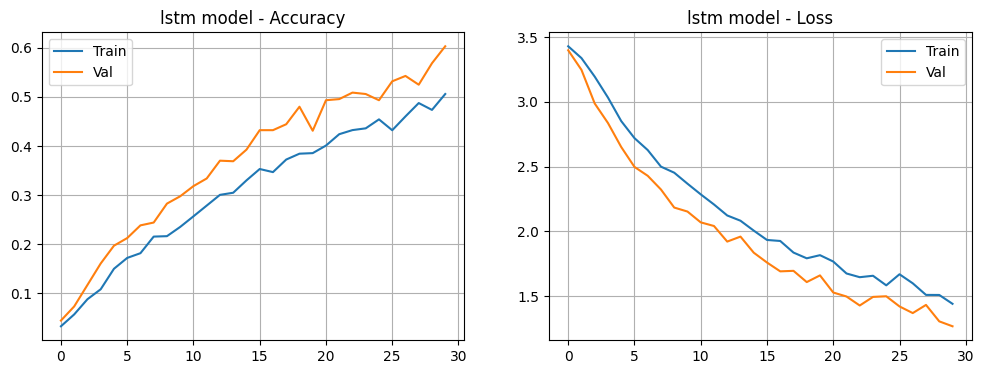

In [20]:
def plot_history(hist, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(hist.history['accuracy'], label='Train')
    ax1.plot(hist.history['val_accuracy'], label='Val')
    ax1.set_title(f'{title} - Accuracy')
    ax1.legend(); ax1.grid()
    ax2.plot(hist.history['loss'], label='Train')
    ax2.plot(hist.history['val_loss'], label='Val')
    ax2.set_title(f'{title} - Loss')
    ax2.legend(); ax2.grid()
    plt.savefig(f'history_{title.lower().replace(" ", "_")}.png')
    plt.show()
plot_history(history, "lstm model")

In [22]:
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"lstm accurasy test:{test_accuracy:.4f}")

lstm accurasy test:0.6923
